In [24]:
import pandas as pd
import numpy as np
import ast

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import lightgbm as lgbm

import xgboost as xgb

from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.regularizers import l1
from keras.callbacks import ModelCheckpoint, TensorBoard

import matplotlib.pyplot as plt
import seaborn as sns

## 1. 임베딩 벡터 columnize

In [7]:
vdim = 256
vcol_name = 'embedding_'+str(vdim)
print(vcol_name)

list_dimensions = []
for i in range(0, vdim):
    el = 'D'+str(i).zfill(3)
    list_dimensions.append(el)


embedding_256


In [ ]:
df = pd.read_csv('vectors_ROW.csv')
list_index = df.index

# Each vector is stored in string. Convert each vector to list first.
series_vectors = df[vcol_name].apply(lambda x: ast.literal_eval(x))
# Then, make the vectors 2D list
list_vectors = series_vectors.to_list()

df_vectors = pd.DataFrame(data=list_vectors, index=list_index, columns=list_dimensions)

df.drop([vcol_name], axis=1, inplace=True)

df_vectors['RECEIPT_NUMBER'] = df['RECEIPT_NUMBER']

df = pd.merge(df, df_vectors, how='left', on=['RECEIPT_NUMBER'])

# df.to_csv('df.csv', index=False)
display(df.head(5))

In [ ]:
df.to_csv('vectors_ROW_columnized.csv', index=False)

In [2]:
df = pd.read_csv('vectors_ROW_columnized.csv')

### Training set와 test set 분리

In [4]:
# training set is 80% of the data
# test set is the other 20% of the data
df_train = df.sample(frac=0.8, random_state=0)
df_test = df.drop(df_train.index)

In [5]:
df_train.to_csv('vectors_ROW_columnized_train.csv', index=False)
df_test.to_csv('vectors_ROW_columnized_test.csv', index=False)

In [ ]:
df_train = pd.read_csv('vectors_ROW_columnized_train.csv')
df_test = pd.read_csv('vectors_ROW_columnized_test.csv')

In [11]:
x_train = df_train[list_dimensions]
y_train = df_train['TO_RECLAIM']

x_test = df_test[list_dimensions]
y_test = df_test['TO_RECLAIM']

### LightGBM on raw vector embedding

In [ ]:
lgbm_train_ds = lgbm.Dataset(x_train, label=y_train)
lgbm_test_ds = lgbm.Dataset(x_test, label=y_test)

lgbm_params = {
    'verbose': -1,
    'learning_rate': 0.01,
    'max_depth': 12,
    'num_leaves': 12,
    'objective': 'binary',
    'metric': 'mae',
    'boosting': 'gbdt',
}

lgbm_model = lgbm.train(params=lgbm_params,
                        train_set=lgbm_train_ds,
                        #num_boost_round=10000,
                        num_boost_round=5000,
                        valid_sets=lgbm_test_ds,
                        #verbose_eval=False,  # True, False, or a number
                        #early_stopping_rounds=1000,
                        )


In [ ]:
y_pred_lgb = lgbm_model.predict(x_test)
y_pred_lgb_binary = np.where(y_pred_lgb > 0.5, 1, 0)

print('LightGBM Model')
accuracy = sum(y_pred_lgb_binary == y_test) / len(y_test)
print("Accuracy:", accuracy)

confusion_matrix(y_test, y_pred_lgb_binary)

### XGBoost on raw vector

In [ ]:
dt = xgb.DMatrix(x_train, label=y_train)
dv = xgb.DMatrix(x_test, label=y_test)

params = {
    "objective": "binary:logistic",
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}

xgb_model = xgb.train(
    params,
    dt,
    num_boost_round=10,
    evals=[(dt, "train"), (dv, "valid")],
    early_stopping_rounds=5,
    verbose_eval=25,
)

In [ ]:
# get the predicted values for the validation set
y_pred = xgb_model.predict(dv)

# convert the predicted values to binary (0 or 1) based on a threshold of 0.5
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]

# calculate the accuracy of the model
accuracy = sum(y_pred_binary == y_test) / len(y_test)
print("Accuracy:", accuracy)

# show me the correctnees by 2x2 table
confusion_matrix(y_test, y_pred_binary)

# distance-based down sampling


### trainset 내의 noclaim samples의 claim sample centroid로부터의 거리 구하기


In [9]:
# train 데이터 분리
df_train_claim = df_train[df_train['TO_RECLAIM'] == 1]
df_train_noclaim = df_train[df_train['TO_RECLAIM'] == 0]

# Claim samples의 centroid 찾기
list_train_claim_centroid = df_train_claim[list_dimensions].mean().to_list()
train_claim_centroid = np.array(list_train_claim_centroid)

# Noclaim samples와의 거리 계산
df_train_noclaim_dist = df_train_noclaim[list_dimensions]
df_train_noclaim_dist['DIST'] = df_train_noclaim_dist.sub(train_claim_centroid, axis=1).pow(2).sum(axis=1).pow(.5)

# merge시 필요한 columns
df_train_noclaim_dist['TO_RECLAIM'] = df_train_noclaim['TO_RECLAIM']

df_train_noclaim_dist_gt = df_train_noclaim_dist.sort_values(by=['DIST'], ascending=False)
df_train_noclaim_dist_lt = df_train_noclaim_dist.sort_values(by=['DIST'], ascending=True)

df_train_noclaim_dist_gt.reset_index(drop=True, inplace=True)
df_train_noclaim_dist_lt.reset_index(drop=True, inplace=True)

len_train_claim = len(df_train_claim)
print(len_train_claim)

if 1:
    df_train_noclaim_undersamples_lt = df_train_noclaim_dist_lt.iloc[0:round(len_train_claim*0.3),:]
    df_train_noclaim_undersamples_gt = df_train_noclaim_dist_gt.iloc[0:round(len_train_claim*0.3),:]

df_train_noclaim_undersamples = pd.concat([df_train_noclaim_undersamples_lt, df_train_noclaim_undersamples_gt], ignore_index=True)

df_train_noclaim_undersamples.drop(['DIST'], axis=1, inplace=True)

df_train_undersamples = pd.concat([df_train_claim, df_train_noclaim_undersamples], ignore_index=True)

display(df_train_noclaim_undersamples.head(5))

/tmp/ipykernel_1046262/269616686.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_noclaim_dist['DIST'] = df_train_noclaim_dist.sub(train_claim_centroid, axis=1).pow(2).sum(axis=1).pow(.5)
/tmp/ipykernel_1046262/269616686.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_noclaim_dist['TO_RECLAIM'] = df_train_noclaim['TO_RECLAIM']


68712


,D000,D001,D002,D003,D004,D005,D006,D007,D008,D009,...,D247,D248,D249,D250,D251,D252,D253,D254,D255,TO_RECLAIM
0,0.138374,-0.284549,-0.033392,-0.307191,0.039143,0.108029,-0.080680,0.179902,0.160821,0.029811,...,0.054246,-0.284017,-0.111485,-0.359349,0.136542,-0.196314,-0.273380,-0.164904,-0.162273,0
1,0.068675,-0.274548,-0.031926,-0.224252,0.135636,0.102746,0.048846,0.164378,0.036756,0.141593,...,0.075583,-0.302468,-0.072611,-0.299988,0.254985,-0.232876,-0.353007,-0.206322,-0.193605,0
2,0.025294,-0.369012,-0.031438,-0.196215,0.035013,0.199964,0.054647,0.173722,0.053604,0.139295,...,0.057621,-0.291454,-0.095370,-0.421083,0.117393,-0.231954,-0.359314,-0.242691,-0.111944,0
3,-0.046049,-0.276145,-0.057233,-0.305155,0.126275,0.213809,0.024099,0.167783,0.055960,0.123505,...,0.057598,-0.294248,-0.079733,-0.491801,0.159948,-0.207696,-0.366883,-0.257488,-0.074938,0
4,-0.040744,-0.176240,-0.122544,-0.207861,-0.030590,0.081388,0.035409,0.266231,0.025400,0.166658,...,-0.029807,-0.313331,-0.073122,-0.325261,0.168605,-0.224603,-0.445860,-0.149842,-0.098833,0


### LGBM model


In [12]:
x_train_u = df_train_undersamples[list_dimensions]
y_train_u = df_train_undersamples[['TO_RECLAIM']]

# Ensemble - Boosting - Random forest classification
lgbm_train_ds = lgbm.Dataset(x_train_u, label=y_train_u)
lgbm_test_ds = lgbm.Dataset(x_test, label=y_test)

lgbm_params = {
    'verbose': -1,
    'learning_rate': 0.01,
    'max_depth': 24,
    'num_leaves': 24,
    'objective': 'binary',
    'metric': 'mae',
    'boosting': 'gbdt',
}

'''
lgbm_params = {
    'verbose': -1,
    'learning_rate': 0.01,
    'max_depth': 31,
    'num_leaves': 31,
    'objective': 'regression',
    'metric': 'mae',
    'boosting': 'gbdt',
}
'''

lgbm_model = lgbm.train(params=lgbm_params,
                        train_set=lgbm_train_ds,
                        #num_boost_round=10000,
                        num_boost_round=5000,
                        valid_sets=lgbm_test_ds,
                        #verbose_eval=False,  # True, False, or a number
                        #early_stopping_rounds=1000,
                        )

[1]	valid_0's l1: 0.500767
[2]	valid_0's l1: 0.500684
[3]	valid_0's l1: 0.500598
[4]	valid_0's l1: 0.500518
[5]	valid_0's l1: 0.500433
[6]	valid_0's l1: 0.500353
[7]	valid_0's l1: 0.500269
[8]	valid_0's l1: 0.500187
[9]	valid_0's l1: 0.500102
[10]	valid_0's l1: 0.500024
[11]	valid_0's l1: 0.499938
[12]	valid_0's l1: 0.499861
[13]	valid_0's l1: 0.499787
[14]	valid_0's l1: 0.499708
[15]	valid_0's l1: 0.499626
[16]	valid_0's l1: 0.499543
[17]	valid_0's l1: 0.499469
[18]	valid_0's l1: 0.49939
[19]	valid_0's l1: 0.499312
[20]	valid_0's l1: 0.49923
[21]	valid_0's l1: 0.499157
[22]	valid_0's l1: 0.49908
[23]	valid_0's l1: 0.499007
[24]	valid_0's l1: 0.498928
[25]	valid_0's l1: 0.498856
[26]	valid_0's l1: 0.498781
[27]	valid_0's l1: 0.498706
[28]	valid_0's l1: 0.498632
[29]	valid_0's l1: 0.498559
[30]	valid_0's l1: 0.49849
[31]	valid_0's l1: 0.498418
[32]	valid_0's l1: 0.498341
[33]	valid_0's l1: 0.498271
[34]	valid_0's l1: 0.498197
[35]	valid_0's l1: 0.498129
[36]	valid_0's l1: 0.498059
[37]	

In [13]:
y_pred_lgb = lgbm_model.predict(x_test)
y_pred_lgb_binary = np.where(y_pred_lgb > 0.5, 1, 0)

print('LightGBM Model')
accuracy = sum(y_pred_lgb_binary == y_test) / len(y_test)
print("Accuracy:", accuracy)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_lgb_binary)

LightGBM Model
Accuracy: 0.5619278092017027


array([[ 3729, 13537],
       [ 1488, 15544]])

### XGBoost Model

In [14]:
dt = xgb.DMatrix(x_train, label=y_train)
dv = xgb.DMatrix(x_test, label=y_test)

dt_u = xgb.DMatrix(x_train_u, label=y_train_u)
dv = xgb.DMatrix(x_test, label=y_test)

params = {
    "objective": "binary:logistic",
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}

xgb_u_model = xgb.train(
    params,
    dt_u,
    num_boost_round=10,
    evals=[(dt_u, "train"), (dv, "valid")],
    early_stopping_rounds=5,
    verbose_eval=25,
)

[0]	train-logloss:0.66894	valid-logloss:0.69124
[4]	train-logloss:0.63462	valid-logloss:0.70094


In [15]:
# get the predicted values for the validation set
y_pred_u = xgb_u_model.predict(dv)

# convert the predicted values to binary (0 or 1) based on a threshold of 0.5
y_pred_binary_u = [1 if x >= 0.5 else 0 for x in y_pred_u]

# calculate the accuracy of the model
accuracy = sum(y_pred_binary_u == y_test) / len(y_test)
print("Accuracy:", accuracy)

# show me the correctnees by 2x2 table
confusion_matrix(y_test, y_pred_binary_u)

Accuracy: 0.5259781911481719


array([[ 1753, 15513],
       [  745, 16287]])

## Autoencoder

In [21]:
# Autoencoder classification
df_train_auto = df_train[df_train['TO_RECLAIM'] == 1]

x_train_auto = df_train_auto[list_dimensions]
y_train_auto = df_train_auto['TO_RECLAIM']

input_dim = len(list_dimensions)
encoding_dim = 128

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                                 verbose=0,
                                 save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                            histogram_freq=0,
                            write_graph=True,
                            write_images=True)

history = autoencoder.fit(x_train_auto, x_train_auto,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history


Epoch 1/100
2148/2148 [==============================] - 14s 6ms/step - loss: 0.0179 - accuracy: 0.9105 - val_loss: 0.0171 - val_accuracy: 0.9155
Epoch 2/100
  36/2148 [..............................] - ETA: 9s - loss: 0.0172 - accuracy: 0.9201

/home/patrick/miniconda3/envs/test/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2148/2148 [==============================] - 12s 6ms/step - loss: 0.0168 - accuracy: 0.9262 - val_loss: 0.0167 - val_accuracy: 0.9294
Epoch 3/100
2148/2148 [==============================] - 12s 6ms/step - loss: 0.0167 - accuracy: 0.9332 - val_loss: 0.0167 - val_accuracy: 0.9332
Epoch 4/100
2148/2148 [==============================] - 13s 6ms/step - loss: 0.0167 - accuracy: 0.9375 - val_loss: 0.0167 - val_accuracy: 0.9347
Epoch 5/100
2148/2148 [==============================] - 12s 6ms/step - loss: 0.0167 - accuracy: 0.9361 - val_loss: 0.0166 - val_accuracy: 0.9366
Epoch 6/100
2148/2148 [==============================] - 13s 6ms/step - loss: 0.0167 - accuracy: 0.9362 - val_loss: 0.0167 - val_accuracy: 0.9354
Epoch 7/100
2148/2148 [==============================] - 13s 6ms/step - loss: 0.0167 - accuracy: 0.9366 - val_loss: 0.0166 - val_accuracy: 0.9323
Epoch 8/100
2148/2148 [==============================] - 13s 6ms/step - loss: 0.0167 - accuracy: 0.9370 - val_loss: 0.0166 - val_accurac

In [25]:
autoencoder = load_model('model.h5')

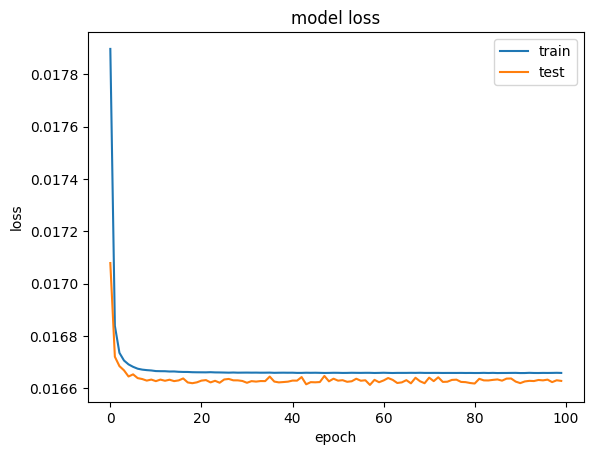

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Prediction

In [30]:
threshold = 0.5


In [28]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

1072/1072 [==============================] - 1s 1ms/step


,reconstruction_error,true_class
count,34298.000000,34298.000000
mean,0.016550,0.496589
std,0.000971,0.499996
min,0.012821,0.000000
25%,0.015890,0.000000
50%,0.016542,0.000000
75%,0.017203,1.000000
max,0.020691,1.000000


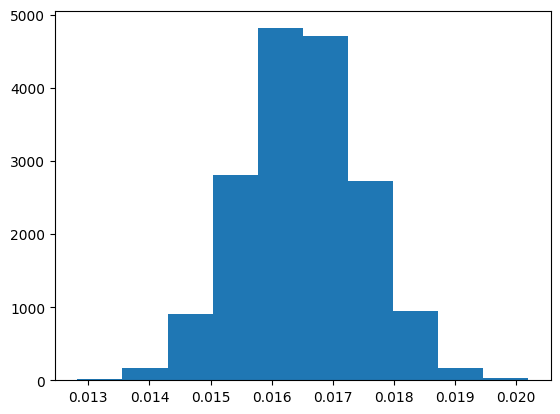

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

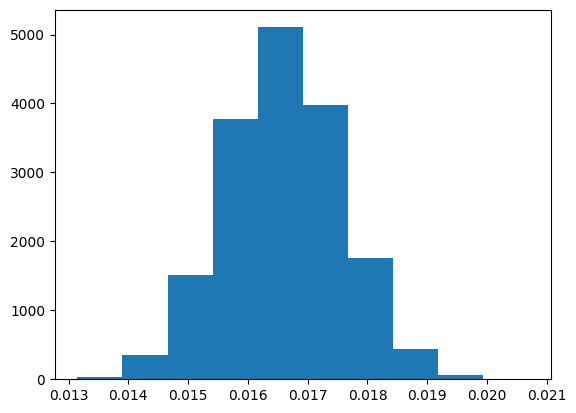

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

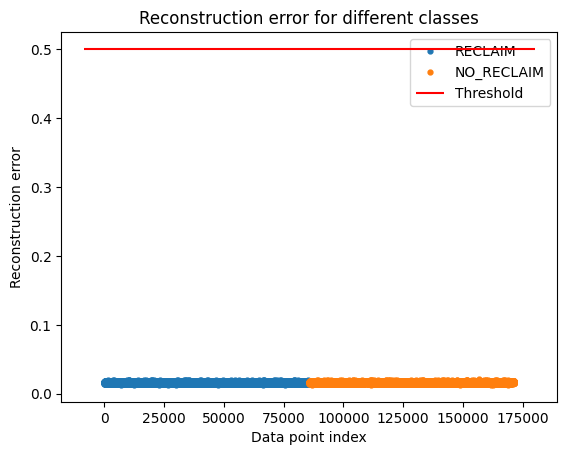

In [31]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "NO_RECLAIM" if name == 1 else "RECLAIM")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### confusion matrix

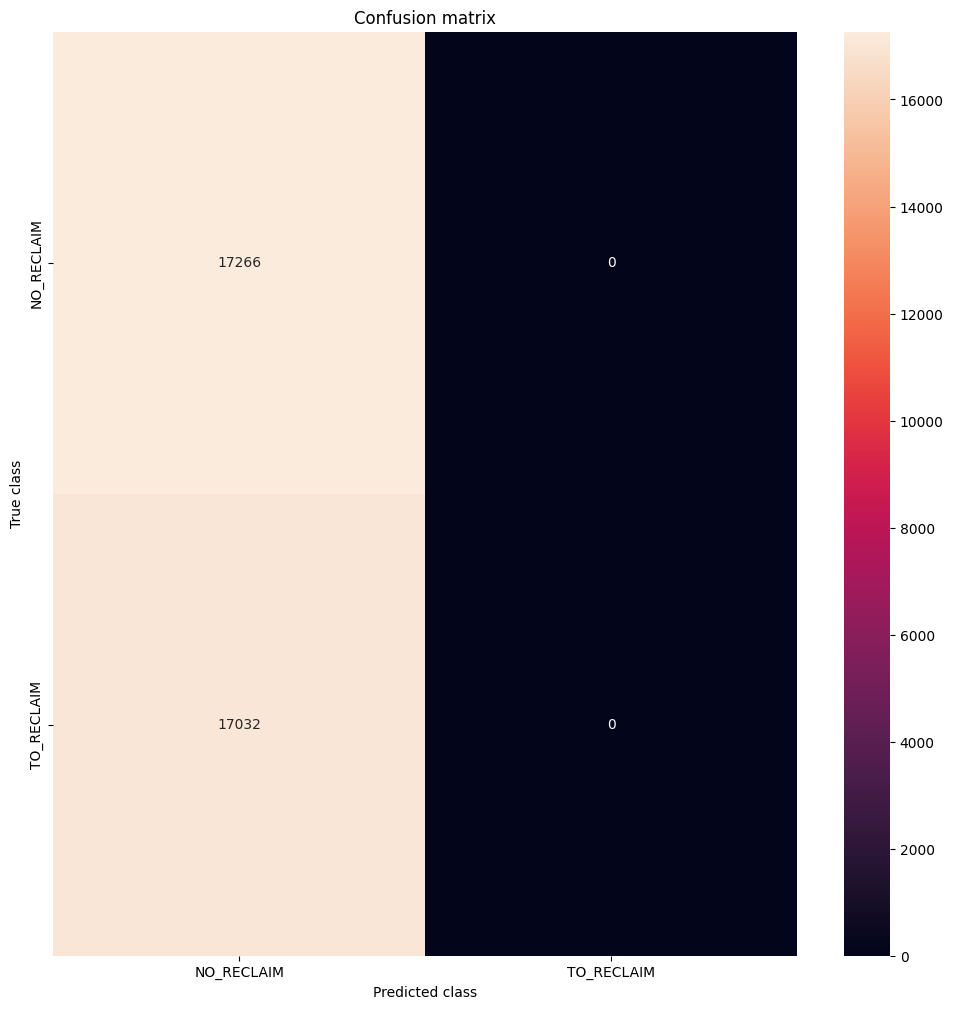

In [33]:
LABELS = ["NO_RECLAIM", "TO_RECLAIM"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()